In [59]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os

In [133]:
import json
# Plot MonoLLM Errors (divide by num items and num turns?)
def error_plot(folder_paths, names, title, y_max=100):
    hallucinations = []
    missings = []
    duplicates = []
    for folder_path in folder_paths:
        errors_path = os.path.join(folder_path, "errors.json")
        if os.path.exists(errors_path):
            with open(errors_path, "r") as errors_file:
                errors = json.load(errors_file)
                hallucinations.append(errors['hallucinations'])
                missings.append(errors['missing'])
                duplicates.append(errors['duplicates'])
                head, tail = os.path.split(folder_path)
                head_2, tail_2 = os.path.split(head)
        else:
            print("Couldn't find", errors_path)
    
    x = np.arange(len(names))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    results = {
        'missing': missings,
        'hallucinations': hallucinations,
        'duplicates': duplicates
    }

    for attribute, measurement in results.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(x + width, names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, y_max)

    plt.show()
            

In [336]:
# Generate a plot of Cumulative Regret from the results in results_csv
def cum_regret_plot(results_csv_file, config, title="", baseline=False, max_y=11, cis=True, n_items=100):
    folder_path = "./"
    num_turns = config['dialogue_sim']['num_turns']
    results_df = pd.read_csv(results_csv_file)

    # Set up colours
    # import pdb; pdb.set_trace()
    colors = mpl.colormaps['viridis']
    colors = [colors(i) for i in np.linspace(0, 1, len(results_df))]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    for row_num in range(len(results_df)):
        row_maps = []
        cum_regret = 0.0
        for turn in range(num_turns):
            cum_regret += (1 - results_df.loc[row_num, 'P_1@%d' % turn])
            row_maps.append(cum_regret)

        plt.plot(np.linspace(1,num_turns,num_turns), row_maps, marker="o", linestyle="solid", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])

    # Temporary - can make a function argument later
    # if baseline:
    #     num_items = n_items
    #     num_recs = 10
    #     p_select_position = 1 / num_items
    #     total_maps = 0.0
    #     for i in range(num_recs):
    #         total_maps += (1 / (i+1))
    #     total_maps *= p_select_position
    #     #print(total_maps)
    #     plt.axhline(y=total_maps, color="r", linestyle="--")

    experiment_names = results_df['Experiment Name'].to_list()
    # experiment_names = sorted(experiment_names)
    for i in range(len(experiment_names)): # Trim experiment names to just the last directory name
        head, tail = os.path.split(experiment_names[i])
        experiment_names[i] = tail

    # Set axis labels
    plt.xticks(np.arange(1, num_turns+1, step=1))
    plt.ylabel('Cumulative Regret')
    plt.xlabel('Turn #')

    # Create a legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(results_df))]
    plt.legend(handles, [exp_name for exp_name in experiment_names], title='Experiments')

    plt.ylim(0,max_y)

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    file_path = os.path.dirname(results_csv_file)
    file_name = os.path.join(file_path, "CR_plot.png")
    fig.savefig(file_name)

    plt.show()

In [139]:
# Generate a plot of MAP from the results in results_csv
def map_plot(results_csv_file, config, title="", baseline=False, max_y=1, cis=True, n_items=100):
    folder_path = "./"
    num_turns = config['dialogue_sim']['num_turns']
    results_df = pd.read_csv(results_csv_file)

    # Set up colours
    # import pdb; pdb.set_trace()
    colors = mpl.colormaps['viridis']
    colors = [colors(i) for i in np.linspace(0, 1, len(results_df))]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.title(title)
    
    for row_num in range(len(results_df)):
        row_maps = []
        upper_bounds = []
        lower_bounds = []
        for turn in range(num_turns):
            row_maps.append(results_df.loc[row_num, 'map@%d' % turn])
            upper_bounds.append(results_df.loc[row_num, 'map@%d_ub' % turn])
            lower_bounds.append(results_df.loc[row_num, 'map@%d_lb' % turn])

        plt.plot(np.linspace(1,num_turns,num_turns), row_maps, marker="o", linestyle="solid", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
        if cis:
            plt.plot(np.linspace(1,num_turns,num_turns), upper_bounds, marker=".", linestyle="--", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
            plt.plot(np.linspace(1,num_turns,num_turns), lower_bounds, marker=".", linestyle="--", color=colors[row_num], label=results_df.loc[row_num, 'Experiment Name'])
            plt.fill_between(np.linspace(1,num_turns,num_turns), upper_bounds, lower_bounds, color=colors[row_num], alpha=.1)

    # Temporary - can make a function argument later
    if baseline:
        num_items = n_items
        num_recs = 10
        p_select_position = 1 / num_items
        total_maps = 0.0
        for i in range(num_recs):
            total_maps += (1 / (i+1))
        total_maps *= p_select_position
        #print(total_maps)
        plt.axhline(y=total_maps, color="r", linestyle="--")

    experiment_names = results_df['Experiment Name'].to_list()
    # experiment_names = sorted(experiment_names)
    for i in range(len(experiment_names)): # Trim experiment names to just the last directory name
        head, tail = os.path.split(experiment_names[i])
        experiment_names[i] = tail

    # Set axis labels
    plt.xticks(np.arange(1, num_turns+1, step=1))
    plt.ylabel('MAP')
    plt.xlabel('Turn #')

    # Create a legend
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(results_df))]
    plt.legend(handles, [exp_name for exp_name in experiment_names], title='Experiments')

    plt.ylim(0,max_y)

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    file_path = os.path.dirname(results_csv_file)
    file_name = os.path.join(file_path, "MAP_plot.png")
    fig.savefig(file_name)

    plt.show()

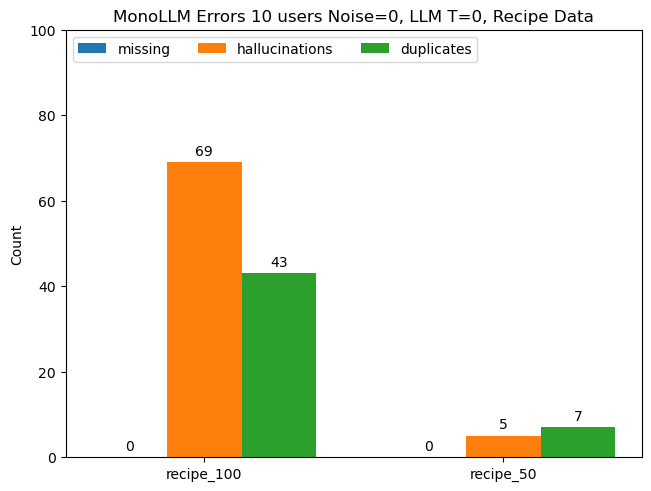

In [135]:
exp_paths = [
    "experiments/jan_18_recipe_100_mono/llm_temp_0_noise_0",
    "experiments/jan_18_recipe_50_monoLLM_0/llm_temp_0_noise_0"
]
names = [
    "recipe_100",
    "recipe_50"
]
error_plot(exp_paths, names, "MonoLLM Errors 10 users Noise=0, LLM T=0, Recipe Data", y_max=100)

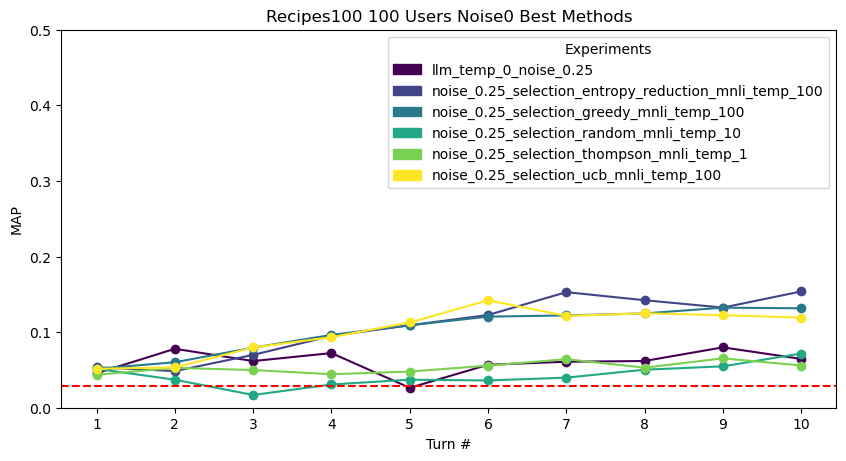

KeyError: 'P_1@0'

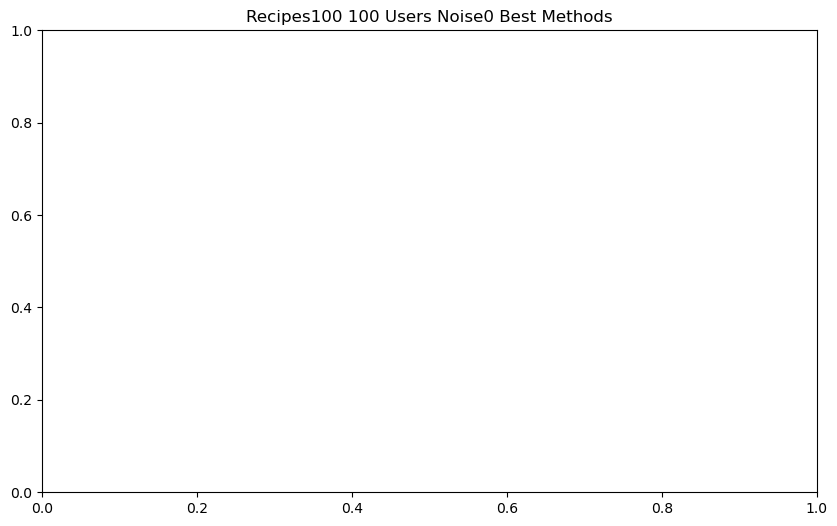

In [338]:
config = {'dialogue_sim': {'num_turns': 10}}
# results_csv_file = "experiments/jan_21_restaurants_100_users_noise0.25_random/aggregated_results.csv"
results_csv_file = "organized_results/restaurants/best/noise0/aggregated_results.csv"

title = "Restaurants100 100 Users Noise0 Best Methods"

map_plot(results_csv_file, config, title, baseline=True, cis = False, n_items = 100, max_y=0.5)
cum_regret_plot(results_csv_file, config, title, baseline=True, cis = False, n_items = 100, max_y=11)